# Banded ridge regression

This tutorial builds on the previous encoding model tutorial to map _multiple_ feature spaces onto brain activity during natural language comprehension. We will use two language models in one joint model: speech embeddings from Whisper's encoder and language embeddings from GPT2-XL. The [Himalaya](https://gallantlab.org/himalaya/index.html) package ([Dupré La Tour et al., 2022](https://doi.org/10.1016/j.neuroimage.2022.119728)) provides code to run and evaluate these joint encoding models (example [tutorial](https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/06_plot_banded_ridge_model.html)).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassonlab/podcast-ecog-tutorials/blob/main/notebooks/06-banded-ridge.ipynb)

In [ ]:
# only run this cell in colab
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install mne mne_bids himalaya scikit-learn pandas matplotlib nilearn

In [1]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.kernel_ridge import Kernelizer, ColumnKernelizer, MultipleKernelRidgeCV
from himalaya.scoring import correlation_score_split

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(display='diagram')

Use a GPU for fitting an encoding model, if available.

In [2]:
if torch.cuda.is_available():
    set_backend("torch_cuda")
    print("Using cuda!")

Using cuda!


## Load GPT-2 embeddings

Similar to previous tutorials, we will load the contextual word embeddings from GPT-2.

In [3]:
bids_root = ""  # if using a local dataset, set this variable accordingly

# Download the transcript, if required
embedding_path = f"{bids_root}stimuli/gpt2-xl/features.hdf5"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$embedding_path
    embedding_path = "features.hdf5"

print(f"Using embedding file path: {embedding_path}")

Using embedding file path: ../../monkey/stimuli/gpt2-xl/features.hdf5


In [4]:
modelname, layer = 'gpt2-xl', 24
with h5py.File(embedding_path, "r") as f:
    contextual_embeddings = f[f"layer-{layer}"][...]
print(f"LLM embedding matrix has shape: {contextual_embeddings.shape}")

LLM embedding matrix has shape: (5491, 1600)


In [5]:
# Download the transcript, if required
transcript_path = f"{bids_root}stimuli/gpt2-xl/transcript.tsv"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$transcript_path
    transcript_path = "transcript.tsv"

# Load transcript
df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model accuracy: {model_acc*100:.3f}%")

df_contextual.head()

Model accuracy: 30.942%


,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,ĠAct,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ġone,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ġmonkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ġin,287,15,0.004237,0,4.444838


In [6]:
aligned_gpt_embeddings = []
for _, group in df_contextual.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = contextual_embeddings[indices].mean(0) # average features
    aligned_gpt_embeddings.append(average_emb)
aligned_gpt_embeddings = np.stack(aligned_gpt_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_gpt_embeddings.shape}")

LLM embeddings matrix has shape: (5136, 1600)


In [7]:
df_word_gpt = df_contextual.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word_gpt.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


## Load Whisper encoder embeddings

We will also load speech embeddings from Whisper (medium size) from the dataset.

In [8]:
# Download the transcript, if required
embedding_path = f"{bids_root}stimuli/whisper-medium/features.hdf5"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$embedding_path
    embedding_path = "features.hdf5"

print(f"Using embedding file path: {embedding_path}")

Using embedding file path: ../../monkey/stimuli/whisper-medium/features.hdf5


In [9]:
with h5py.File(embedding_path, "r") as f:
    whisper_embeddings = f["vectors"][...]
print(f"LLM embedding matrix has shape: {whisper_embeddings.shape}")

LLM embedding matrix has shape: (5134, 2048)


In [10]:
# Download the transcript, if required
transcript_path = f"{bids_root}stimuli/whisper-medium/transcript.tsv"
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$transcript_path
    transcript_path = "transcript.tsv"

# Load transcript
df_whisper = pd.read_csv(transcript_path, sep="\t", index_col=0)
df_whisper.head()

,word_idx,word,start,end
0,0,Act,3.710,3.790
1,1,"one,",3.990,4.190
2,2,monkey,4.651,4.931
3,3,in,4.951,5.011
4,4,the,5.051,5.111


In [11]:
aligned_whisper_embeddings = []
for _, group in df_whisper.groupby("word_idx"): # group by word index
    indices = group.index.to_numpy()
    average_emb = whisper_embeddings[indices].mean(0) # average features
    aligned_whisper_embeddings.append(average_emb)
aligned_whisper_embeddings = np.stack(aligned_whisper_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_whisper_embeddings.shape}")

LLM embeddings matrix has shape: (5134, 2048)


In [12]:
df_word_whisper = df_whisper.groupby("word_idx").agg(dict(word="first", start="first", end="last"))
df_word_whisper.head()

,word,start,end
word_idx,,,
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111


Because we are using two different kinds of language models, they may have different tokenizers and thus their embeddings may not be aligned. We'll aligns their transcripts together here.

In [13]:
df_merged = pd.merge(df_word_gpt, df_word_whisper, left_index=True, right_index=True)
df_merged

,word_x,start_x,end_x,word_y,start_y,end_y
word_idx,,,,,,
0,Act,3.710,3.790,Act,3.710,3.790
1,"one,",3.990,4.190,"one,",3.990,4.190
2,monkey,4.651,4.931,monkey,4.651,4.931
3,in,4.951,5.011,in,4.951,5.011
4,the,5.051,5.111,the,5.051,5.111
...,...,...,...,...,...,...
5131,go,1798.546,1798.646,go,1798.546,1798.646
5132,to,1798.666,1798.746,to,1798.666,1798.746
5133,court,1798.786,1799.006,court,1798.786,1799.006


## Loading brain data

Next, we will load the preprocessed high-gamma ECoG data using MNE. Here, we will demonstrate loading data from our third subject.

In [14]:
file_path = BIDSPath(root=f"{bids_root}derivatives/ecogprep",
                    subject="03", task="podcast", datatype="ieeg", description="highgamma",
                    suffix="ieeg", extension=".fif")
print(f"File path within the dataset: {file_path}")

# You only need to run this if using Colab (i.e. if you did not set bids_root to a local directory)
if not len(bids_root):
    !wget -nc https://s3.amazonaws.com/openneuro.org/ds005574/$file_path
    file_path = file_path.basename

raw = mne.io.read_raw_fif(file_path, verbose=False)
picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
raw = raw.pick(picks)
raw

File path within the dataset: ../../monkey/derivatives/ecogprep/sub-03/ieeg/sub-03_task-podcast_desc-highgamma_ieeg.fif


<Raw | sub-03_task-podcast_desc-highgamma_ieeg.fif, 127 x 921600 (1800.0 s), ~187 kB, data not loaded>

We will map the start information (in seconds) of each word in the dataframe onto the brain signal data by multiplying by the sampling rate. Here the first column of `events` mark the start of each word on the brain signal data.

In [15]:
events = np.zeros((len(df_merged), 3), dtype=int)
events[:, 0] = (df_merged.start_x * raw.info['sfreq']).astype(int)
events.shape

(5134, 3)

Then we'll take advantage of MNE's tools for creating epochs around stimulus events, which here are the starts (onsets) of each word, to visualize brain signal that respond to word onsets. Here, we take a fixed-width window ranging from -2 seconds to +2 seconds relative to word onset. Since the sampling rate is 512 Hz (512 samples per second), we have 2049 lags total. The ECoG data is a numpy array with the shape of (number of words * number of ECoG electrodes * number of lags).

In [16]:
epochs = mne.Epochs(
    raw,
    events,
    tmin=-2.0,
    tmax=2.0,
    baseline=None,
    proj=False,
    event_id=None,
    preload=True,
    event_repeated="merge",
)
print(f"Epochs object has a shape of: {epochs._data.shape}")

Not setting metadata
5134 matching events found
No baseline correction applied
Loading data for 5134 events and 2049 original time points ...


/tmp/ipykernel_3099603/3482921024.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


6 bad epochs dropped
Epochs object has a shape of: (5128, 127, 2049)


Next, we'll downsample the temporal resolution to 32 Hz, which reduces the number of lags to 32 * 4 = 128.

<div class="alert alert-info">

**Note**

This code block may take ~3 minutes to run.

</div>

In [17]:
epochs = epochs.resample(sfreq=32, npad='auto', method='fft', window='hamming')
print(f"Epochs object has a shape of: {epochs._data.shape}")

Epochs object has a shape of: (5128, 127, 128)


## Setting up feature and brain data

Now we have both the features and the ECoG data ready. We plan to fit encoding models at each electrode and for each lag, so we'll reshape our target matrix `Y` to horizontally stack both electrodes and lags along the second dimension.

In [18]:
epochs_data = epochs.get_data(copy=True)
epochs_data = epochs_data.reshape(len(epochs), -1)
print(f"ECoG data matrix shape: {epochs_data.shape}")

ECoG data matrix shape: (5128, 16256)


We will also align our features with the ECoG data. At the same time, we need to construct one design matrix as predictor variables in our encoding model. We do this by horizontally stacking the embeddings together, to get one wide model:

In [19]:
gpt2_embeddings = aligned_gpt_embeddings[epochs.selection]
whisper_embeddings = aligned_whisper_embeddings[epochs.selection]
input_embeddings = np.hstack((gpt2_embeddings, whisper_embeddings))

print(f"Combined model embeddings size: {input_embeddings.shape}")

Combined model embeddings size: (5128, 3648)


We will change the float precision to float32 for all data to take advantage of the GPU memory and computational speed.

In [20]:
X = input_embeddings
Y = epochs_data

if "torch" in get_backend().__name__:
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

X.shape, Y.shape

((5128, 3648), (5128, 16256))

## Building the encoding model

This section closely follows the Himalaya [banded ridge tutorial](https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/06_plot_banded_ridge_model.html) to construct an encoding model pipeline prior to fitting.

In [21]:
preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Kernelizer(kernel="linear"),
)
preprocess_pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('kernelizer', Kernelizer())])

In [22]:
feature_names = ['gpt2', 'whisper']
slices = [slice(0, 1600), slice(1600, None)]

kernelizers_tuples = [(name, preprocess_pipeline, slice_)
                      for name, slice_ in zip(feature_names, slices)]
column_kernelizer = ColumnKernelizer(kernelizers_tuples)
column_kernelizer

ColumnKernelizer(transformers=[('gpt2',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('kernelizer', Kernelizer())]),
                                slice(0, 1600, None)),
                               ('whisper',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler(with_std=False)),
                                                ('kernelizer', Kernelizer())]),
                                slice(1600, None, None))])

In [23]:
n_iter = 20
alphas = np.logspace(1, 10, 10) # specify alpha values
inner_cv = KFold(n_splits=5, shuffle=False) # inner 5-fold cross-validation setup

solver_params = dict(n_iter=n_iter, alphas=alphas)
mkr_model = MultipleKernelRidgeCV(kernels="precomputed", solver='random_search',
                              solver_params=solver_params, cv=inner_cv)

mkr_model

MultipleKernelRidgeCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                      kernels='precomputed',
                      solver_params={'alphas': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                                     'n_iter': 20})

In [24]:
model = make_pipeline(
    column_kernelizer,
    mkr_model,
)
model

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('gpt2',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 1600, None)),
                                                ('whisper',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1600, None, None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                                       kernels='precomputed',
                                       solver_params={'alphas': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                                                      'n_iter': 20}))])

## Training encoding models

<div class="alert alert-info">

This code block may take a while to run. Make sure you are using a GPU if you have one (verify by running `nvidia-smi`). You may also consider resampling the epochs even further to use fewer lags, and/or choose specific electrodes to run to use fewer electrodes.

</div>

In [25]:
epochs_shape = epochs._data.shape[1:] # number of electrodes * number of lags

def train_encoding(X, Y):

    corrs = [] # empty array to store correlation results
    kfold = KFold(2, shuffle=False) # outer 2-fold cross-validation setup
    for train_index, test_index in kfold.split(X): # loop through folds

        # Split train and test datasets
        X1_train, X1_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Standardize Y
        scaler = StandardScaler()
        Y_train = scaler.fit_transform(Y_train)
        Y_test = scaler.transform(Y_test)

        model.fit(X1_train, Y_train) # Fit pipeline with transforms and ridge estimator
        Y_preds = model.predict(X1_test, split=True) # Use trained model to predict on test set
        corr = correlation_score_split(Y_test, Y_preds) # Compute correlation score

        if "torch" in get_backend().__name__: # if using gpu, transform tensor back to numpy
            corr = corr.numpy(force=True)

        corrs.append(corr) # append fold correlation results to final results
    return np.stack(corrs)

# set_backend("torch") # resort to torch or numpy if cuda out of memory
corrs_embedding = train_encoding(X, Y)
corrs_embedding = corrs_embedding.reshape(2, 2, *epochs_shape)
print(f"Encoding performance correlating matrix shape: {corrs_embedding.shape}")

[........................................] 100% | 22.45 sec | 20 random sampling with cv | 
[........................................] 100% | 19.45 sec | 20 random sampling with cv | 
Encoding performance correlating matrix shape: (2, 2, 127, 128)


## Plotting encoding performance

In [29]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (127, 3)


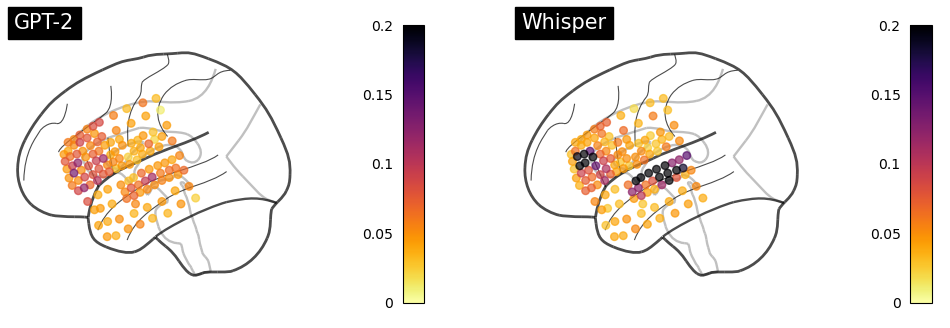

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

values = corrs_embedding[:, 0].mean(0).max(-1)
order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='l',
             figure=fig, axes=axes[0],
             node_vmin=0,  node_vmax=0.2,
             title="GPT-2",
             node_cmap='inferno_r', colorbar=True)


values = corrs_embedding[:, 1].mean(0).max(-1)
order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='l',
             figure=fig, axes=axes[1],
             node_vmin=0,  node_vmax=0.2,
             title="Whisper",
             node_cmap='inferno_r', colorbar=True)

fig.show()